In [1]:
#import proglearn
#from proglearn.forest import UncertaintyForest
import hyppo
import numpy as np
from numba import njit
from hyppo.independence.base import IndependenceTest
from hyppo._utils import perm_test
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import copy 
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree._classes import DecisionTreeClassifier
from joblib import Parallel, delayed
from scipy.stats import entropy, multivariate_normal
from scipy.integrate import nquad

In [2]:
import sys
sys.executable
sys.path
sys.path.append('C:\\Users\\siptest\\AppData\\Roaming\\Python\\Python36\\Scripts')

In [3]:
def uf(X, y, n_estimators = 300, max_samples = .4, base = np.exp(1), kappa = 3):
    
    # Build forest with default parameters.
    model = BaggingClassifier(DecisionTreeClassifier(), 
                              n_estimators=n_estimators, 
                              max_samples=max_samples, 
                              bootstrap=False)
    model.fit(X, y)
    n = X.shape[0]
    K = model.n_classes_
    _, y = np.unique(y, return_inverse=True)
    
    cond_entropy = 0
    for tree_idx, tree in enumerate(model):
        # Find the indices of the training set used for partition.
        sampled_indices = model.estimators_samples_[tree_idx]
        unsampled_indices = np.delete(np.arange(0,n), sampled_indices)
        
        # Randomly split the rest into voting and evaluation.
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        vote_indices = unsampled_indices[:total_unsampled//2]
        eval_indices = unsampled_indices[total_unsampled//2:]
        
        # Store the posterior in a num_nodes-by-num_classes matrix.
        # Posteriors in non-leaf cells will be zero everywhere
        # and later changed to uniform.
        node_counts = tree.tree_.n_node_samples
        class_counts = np.zeros((len(node_counts), K))
        est_nodes = tree.apply(X[vote_indices])
        est_classes = y[vote_indices]
        for i in range(len(est_nodes)):
            class_counts[est_nodes[i], est_classes[i]] += 1
        
        row_sums = class_counts.sum(axis=1) # Total number of estimation points in each leaf.
        row_sums[row_sums == 0] = 1 # Avoid divide by zero.
        class_probs = class_counts / row_sums[:, None]
        
        # Make the nodes that have no estimation indices uniform.
        # This includes non-leaf nodes, but that will not affect the estimate.
        class_probs[np.argwhere(class_probs.sum(axis = 1) == 0)] = [1 / K]*K
        
        # Apply finite sample correction and renormalize.
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1 / (kappa*class_counts.sum(axis = 1)[elem[0]])
        row_sums = class_probs.sum(axis=1)
        class_probs = class_probs / row_sums[:, None]
        
        # Place evaluation points in their corresponding leaf node.
        # Store evaluation posterior in a num_eval-by-num_class matrix.
        eval_class_probs = class_probs[tree.apply(X[eval_indices])]
        # eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_entropies = [entropy(posterior) for posterior in eval_class_probs]
        cond_entropy += np.mean(eval_entropies)

      
    return cond_entropy / n_estimators
        

In [4]:
def generate_data2(n, d, mu = 1):
    n_1 = np.random.binomial(n, .5) # number of class 1
    mean = np.zeros(d)
    mean[0] = mu
    X_1 = np.random.multivariate_normal(mean, np.eye(d), n_1)
    
    X = np.concatenate((X_1, np.random.multivariate_normal(-mean, np.eye(d), n - n_1)))
    y = np.concatenate((np.repeat(1, n_1), np.repeat(0, n - n_1)))
  
    return X, y

In [5]:
def generate_data(n, d, mu = 1, var1 = 1, pi = 0.5, three_class = False):
    
    means, Sigmas, probs = _make_params(d, mu = mu, var1 = var1, pi = pi, three_class = three_class)
    counts = np.random.multinomial(n, probs, size = 1)[0]
    
    X_data = []
    y_data = []
    for k in range(len(probs)):
        X_data.append(np.random.multivariate_normal(means[k], Sigmas[k], counts[k]))
        y_data.append(np.repeat(k, counts[k]))
    X = np.concatenate(tuple(X_data))
    y = np.concatenate(tuple(y_data))
    
    return X, y

In [6]:
def _make_params(d, mu = 1, var1 = 1, pi = 0.5, three_class = False):
    
    if three_class:
        return _make_three_class_params(d, mu, pi)
    
    mean = np.zeros(d)
    mean[0] = mu
    means = [mean, -mean]

    Sigma1 = np.eye(d)
    Sigma1[0, 0] = var1
    Sigmas = [np.eye(d), Sigma1]
    
    probs = [pi, 1 - pi]
    
    return means, Sigmas, probs

def _make_three_class_params(d, mu, pi):
    
    means = []
    mean = np.zeros(d)
    
    mean[0] = mu
    means.append(copy.deepcopy(mean))
    
    mean[0] = -mu
    means.append(copy.deepcopy(mean))
    
    mean[0] = 0
    mean[d-1] = mu
    means.append(copy.deepcopy(mean))
    
    Sigmas = [np.eye(d)]*3
    probs = [pi, (1 - pi) / 2, (1 - pi) / 2]
    
    return means, Sigmas, probs

In [7]:
def compute_mutual_info(d, base = np.exp(1), mu = 1, var1 = 1, pi = 0.5, three_class = False):
    
    if d > 1:
        dim = 2
    else:
        dim = 1
 
    means, Sigmas, probs = _make_params(dim, mu = mu, var1 = var1, pi = pi, three_class = three_class)
    
    # Compute entropy and X and Y.
    def func(*args):
        x = np.array(args)
        p = 0
        for k in range(len(means)):
            p += probs[k] * multivariate_normal.pdf(x, means[k], Sigmas[k])
        return -p * np.log(p) / np.log(base)

    scale = 10
    lims = [[-scale, scale]]*dim
    H_X, int_err = nquad(func, lims)
    H_Y = entropy(probs, base = base)
    
    # Compute MI.
    H_XY = 0
    for k in range(len(means)):
        H_XY += probs[k] * (dim * np.log(2*np.pi) + np.log(np.linalg.det(Sigmas[k])) + dim) / (2 * np.log(base))
    I_XY = H_X - H_XY
    
    return I_XY, H_X, H_Y

In [27]:
#n = 20 used for csv 1, 2
n = 50 
#n = 6000
mus = range(5)
ds = range(1, 16)
mu = 1
num_trials = 10
#reps = 1
d = 2
pis = [0.05 * i for i in range(1, 20)]

def estimate_mi(X, y, est_H_Y, norm_factor): 
    return (est_H_Y - uf(np.array(X), y)) / norm_factor

def mi(X, y, n, d, pis, num_trials):
    #def worker(t): 
        #X, y = generate_data(n, d, pi = elem)
        
        #I_XY, H_X, H_Y = compute_mutual_info(d, pi = elem)
        I_XY, H_X, H_Y = compute_mutual_info(d)
        norm_factor = min(H_X, H_Y)
        
        _, counts = np.unique(y, return_counts=True)
        est_H_Y = entropy(counts, base=np.exp(1))
        ret = []
        ret.append(estimate_mi(X, y, est_H_Y, norm_factor))
        #return tuple(ret)
        return ret[0]
    
    #output = np.zeros((len(pis), num_trials))
    #for i, elem in enumerate(pis): 
        #results = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        #output[i, :] = results[:, 0]
    #return output
    

In [9]:
#conditional entropy as test stat

#

In [28]:
def _perm_stat(X, y, is_distsim = True, permuter = None): 
    if permuter is None: 
        order = np.random.permutation(y.shape[0])
    else: 
        order = permuter()
    
    if is_distsim: 
        permy = y[order][:, order]
    else: 
        permy = y[order]
    
    perm_stat = mi(X, permy, n, d, pis, num_trials)
    
    return perm_stat

In [29]:
def perm_test(X, y, workers = -1, is_distsim=True, perm_block = None, reps = 5): 

    # calculate observed test statistic
    stat = mi(X, y, n, d, pis, num_trials)
    #print(stat) 

    # calculate null distribution
    null_dist = np.array(
        Parallel(n_jobs=-2)(
            [
                delayed(_perm_stat)(X, y, False) 
                for rep in range(reps)
            ]
        )
    )
            
    pvalue = (null_dist >= stat).sum() / reps

    # correct for a p-value of 0. This is because, with bootstrapping
    # permutations, a p-value of 0 is incorrect
    if pvalue == 0:
        pvalue = 1 / reps

    #return stat, pvalue, null_dist
    print(stat, pvalue, null_dist)
    return pvalue

In [30]:
#get a bunch of pvalues for bunch of sample sizes, effect sizes, numbers 
# get 1000 pvalues, do empirical distribution to figure out independence, should get straight line 
#multimodal independence simulations are best places to start 

#X, y = generate_data(n, d)
#print(perm_test(X, y))
pvalues = []
for i in range(1,11): 
    print("\nNumber of reps: " + str(i*10) + "\n")
    print("test statistic, p-value, null distribution")
    X, y = generate_data(n, d)
    #print(perm_test(X, y, reps = i*10))
    pvalues.append(perm_test(X,y,reps=i*10))
np.savetxt('C:/Users/siptest/Desktop/NDD/permTestPvalues3.csv', pvalues, delimiter=',')



Number of reps: 10

test statistic, p-value, null distribution
0.21352514793994345 0.1 [0.13497903 0.15226767 0.14415419 0.14737289 0.15065427 0.13741262
 0.13934995 0.15362029 0.15662749 0.14165094]

Number of reps: 20

test statistic, p-value, null distribution
0.2967401344304713 0.05 [0.12337424 0.11597431 0.1230892  0.11939737 0.11460159 0.11575758
 0.13292944 0.12944883 0.11115531 0.13845408 0.12465434 0.12637958
 0.13902848 0.10644779 0.12112554 0.11862878 0.11668001 0.12020331
 0.12322441 0.11929589]

Number of reps: 30

test statistic, p-value, null distribution
0.2953821688841645 0.03333333333333333 [0.11979488 0.12720543 0.1227963  0.11206747 0.14022339 0.11635001
 0.12212468 0.12439986 0.13326409 0.10630667 0.11980887 0.16124391
 0.11456228 0.12020526 0.11721142 0.1106779  0.1241245  0.13233615
 0.12397178 0.12683877 0.12697356 0.11462875 0.12143919 0.14628602
 0.12310499 0.1225214  0.12044104 0.11084379 0.12839504 0.1199754 ]

Number of reps: 40

test statistic, p-value, n

In [44]:
pvalues = []
for i in range(1,11): 
    print("\nNumber of reps: " + str(i*10) + "\n")
    print("test statistic, p-value, null distribution")
    X, y = generate_data(100, d)
    #print(perm_test(X, y, reps = i*10))
    pvalues.append(perm_test(X,y,reps=i*10))
np.savetxt('C:/Users/siptest/Desktop/NDD/permTestPvalues4.csv', pvalues, delimiter=',')


Number of reps: 10

test statistic, p-value, null distribution
0.3783756708303156 0.1 [0.14250475 0.14145135 0.13271903 0.13054575 0.13720877 0.13527698
 0.12781455 0.13615544 0.13473225 0.13384861]

Number of reps: 20

test statistic, p-value, null distribution
0.32324613755490095 0.05 [0.15492918 0.13621364 0.13568882 0.13589721 0.14061572 0.1471905
 0.13089058 0.13059297 0.15060955 0.12432423 0.13572225 0.13434876
 0.13192707 0.14469321 0.13314382 0.13883889 0.13587316 0.150304
 0.12402977 0.12842341]

Number of reps: 30

test statistic, p-value, null distribution
0.3552384670773354 0.03333333333333333 [0.1375507  0.13296838 0.14193935 0.13126165 0.14071561 0.15824922
 0.12708893 0.13122677 0.13196326 0.13800217 0.13246109 0.13264857
 0.13351672 0.13155893 0.14519674 0.13619068 0.13771228 0.13025469
 0.13334206 0.13111432 0.13912728 0.12811054 0.13942682 0.12868468
 0.14130482 0.13170764 0.13599181 0.12307113 0.13403091 0.14126258]

Number of reps: 40

test statistic, p-value, null

KeyboardInterrupt: 

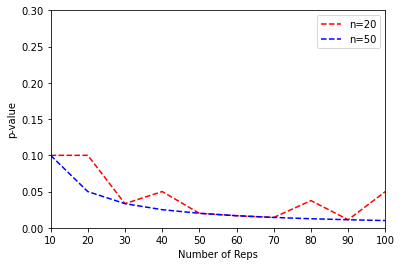

In [43]:
pvals = np.genfromtxt('C:/Users/siptest/Desktop/NDD/permTestPvalues2.csv', delimiter=',')
pvals2 = np.genfromtxt('C:/Users/siptest/Desktop/NDD/permTestPvalues3.csv', delimiter=',')
plt.plot([10, 20, 30, 40, 50, 60, 70, 80, 90, 100], pvals, 'r--', label = "n=20")
plt.plot([10, 20, 30, 40, 50, 60, 70, 80, 90, 100], pvals2, 'b--', label = "n=50")
plt.axis([10, 100, 0, 0.3])
plt.xlabel("Number of Reps")
plt.ylabel("p-value")
plt.legend()